# Loan repayment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

random_seed = 42

import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import os, sys, json

from sklearn.preprocessing import  StandardScaler , OneHotEncoder 


from sklearn.linear_model import LinearRegression,  SGDRegressor, Ridge, RidgeCV

# from sklearn.model_selection import train_test_split #cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold, LeaveOneOut, cross_validate
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestRegressor, StackingRegressor

# #from sklearn import metrics

# from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, StackingClassifier

from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, roc_curve, roc_auc_score, f1_score, median_absolute_error, PredictionErrorDisplay

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
 
#from models.models import ModelSequential

import optuna
import pickle

# Hides output while after model learned
from IPython.display import clear_output

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

#set path
sys.path.insert(1, '../')

#!pip freeze > requirements.txt

In [2]:
from utils.config_reader import config_reader
from utils.functions import get_professions, get_comparison, get_ROC_plot,get_sigma_limits, get_descr
from utils.models_utils import f1, callbacks


# Import parameters
config = config_reader('../config/config.json')

random_seed = config.random_seed
path_figures = config.path_figures

os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
from optuna.samplers import TPESampler
sampler = TPESampler(seed=random_seed) # fix random seed

## Read files

In [3]:
#features_dscr = pd.read_excel('../data/Features.xlsx') #
#features_dscr

In [4]:
# df = pd.read_csv('../data/accepted_2007_to_2018Q4.csv.gz')
# df

# sample = df.sample(n=100000 , axis=0, random_state=random_seed)
# display(sample)
# sample.to_csv('../data/sample.csv') 

In [5]:
data_orig = pd.read_csv('../data/sample.zip', )
data_orig.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
data_orig.tail()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,...,settlement_date,settlement_amount,settlement_percentage,settlement_term
99995,NaN,22000.0,22000.0,22000.0,...,NaN,NaN,NaN,NaN
99996,NaN,25200.0,25200.0,25200.0,...,NaN,NaN,NaN,NaN
99997,NaN,10000.0,10000.0,10000.0,...,NaN,NaN,NaN,NaN
99998,NaN,20000.0,20000.0,20000.0,...,NaN,NaN,NaN,NaN
99999,NaN,12000.0,12000.0,12000.0,...,NaN,NaN,NaN,NaN


Read feature description.

# 0. Dataset preparation

In order to do feature analysis it is better to start from object columns

In [6]:
data_orig.columns.to_list()

['member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joi

In [7]:
# num_features, cat_features = [s for s in data_orig.columns if data_orig[s].dtypes != 'object'], [s for s in data_orig.columns if data_orig[s].dtypes == 'object']
# #cat_features

In order to do feature analysis we should select features which might affect the target.

In [8]:
selected_cols = [
    'loan_amnt', 'delinq_amnt', 'total_rec_prncp', 'total_rec_int', 'total_pymnt',
 'term', 'int_rate', 'installment',  'last_pymnt_d','last_pymnt_amnt', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'chargeoff_within_12_mths',\
    'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status','pymnt_plan',\
    'purpose','title','zip_code','dti','earliest_cr_line','open_acc','pub_rec','revol_bal',\
    'revol_util','total_acc','initial_list_status','application_type','mort_acc','pub_rec_bankruptcies',\
    'hardship_flag', \
    'funded_amnt',
] #settlement_percentage, 'mths_since_last_delinq', ,'hardship_length','total_bal_il'

data = data_orig[selected_cols]
data.head()

,loan_amnt,delinq_amnt,total_rec_prncp,total_rec_int,...,mort_acc,pub_rec_bankruptcies,hardship_flag,funded_amnt
0,32000.0,0.0,24818.09,8858.11,...,2.0,0.0,N,32000.0
1,9600.0,0.0,9600.00,2043.97,...,0.0,1.0,N,9600.0
2,4000.0,0.0,4000.00,368.84,...,2.0,0.0,N,4000.0
3,6025.0,0.0,6025.00,517.49,...,0.0,0.0,N,6025.0
4,25000.0,0.0,3045.86,6651.30,...,0.0,0.0,N,25000.0


# 1. EDA

### Loan_status (target feature)

There are several loan repayment outcomes which can be used as targets.

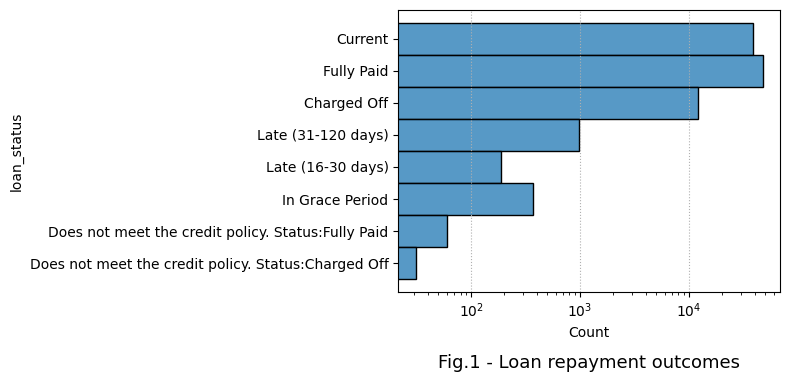

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
fig = sns.histplot(data, y='loan_status')
fig.set_title('Fig.1 - Loan repayment outcomes', y=-0.3, fontsize=13)
ax.set_xscale('log')

plt.tight_layout()
ax.xaxis.grid(linestyle=':')
plot_counter=1
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

To simplify the task let us exclude customers who either do not meet the credit policy or who are in the grace period.

In [10]:
data['loan_status'].value_counts(True)

Fully Paid                                             0.474619
Current                                                0.388886
Charged Off                                            0.120345
Late (31-120 days)                                     0.009690
In Grace Period                                        0.003680
Late (16-30 days)                                      0.001870
Does not meet the credit policy. Status:Fully Paid     0.000600
Does not meet the credit policy. Status:Charged Off    0.000310
Name: loan_status, dtype: float64

In [11]:
data = data.query("loan_status in ['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)']") #'Current',

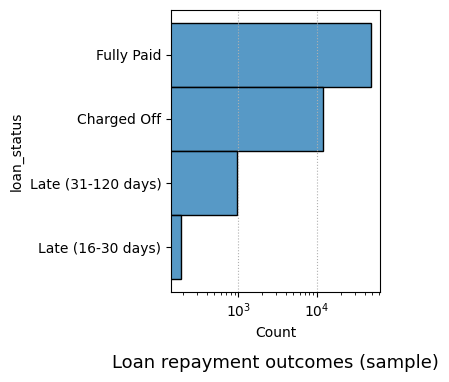

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
fig = sns.histplot(data, y='loan_status')
fig.set_title('Loan repayment outcomes (sample)', y=-0.3, fontsize=13)
ax.set_xscale('log')

plt.tight_layout()
ax.xaxis.grid(linestyle=':')
plot_counter=2
#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [13]:
# data = data[['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', \
#     'emp_title', 'emp_length','loan_status']]

### issue_d

In [14]:
get_descr('issue_d')

The month which the loan was funded


In [15]:
data['issue_d']

1        May-2014
2        Apr-2015
3        Dec-2017
5        Aug-2016
           ...   
99994    Dec-2015
99996    Mar-2015
99997    Sep-2012
99999    Mar-2015
Name: issue_d, Length: 60650, dtype: object

In [16]:
data['issue_d'] = pd.to_datetime(data['issue_d'], errors='coerce').dt.date
data['issued_year'] = pd.to_datetime(data['issue_d'], errors='coerce').dt.year
# data['issued_month'] = pd.to_datetime(data['issue_d'], errors='coerce').dt.month

In [17]:
new_order = list(np.sort(data['issue_d'].unique()))
print('Number of unique categories: ', len(new_order))
temp1 = data[(data['loan_status']=='Fully Paid') | (data['loan_status']=='Charged Off')]
temp2 = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')]

Number of unique categories:  136


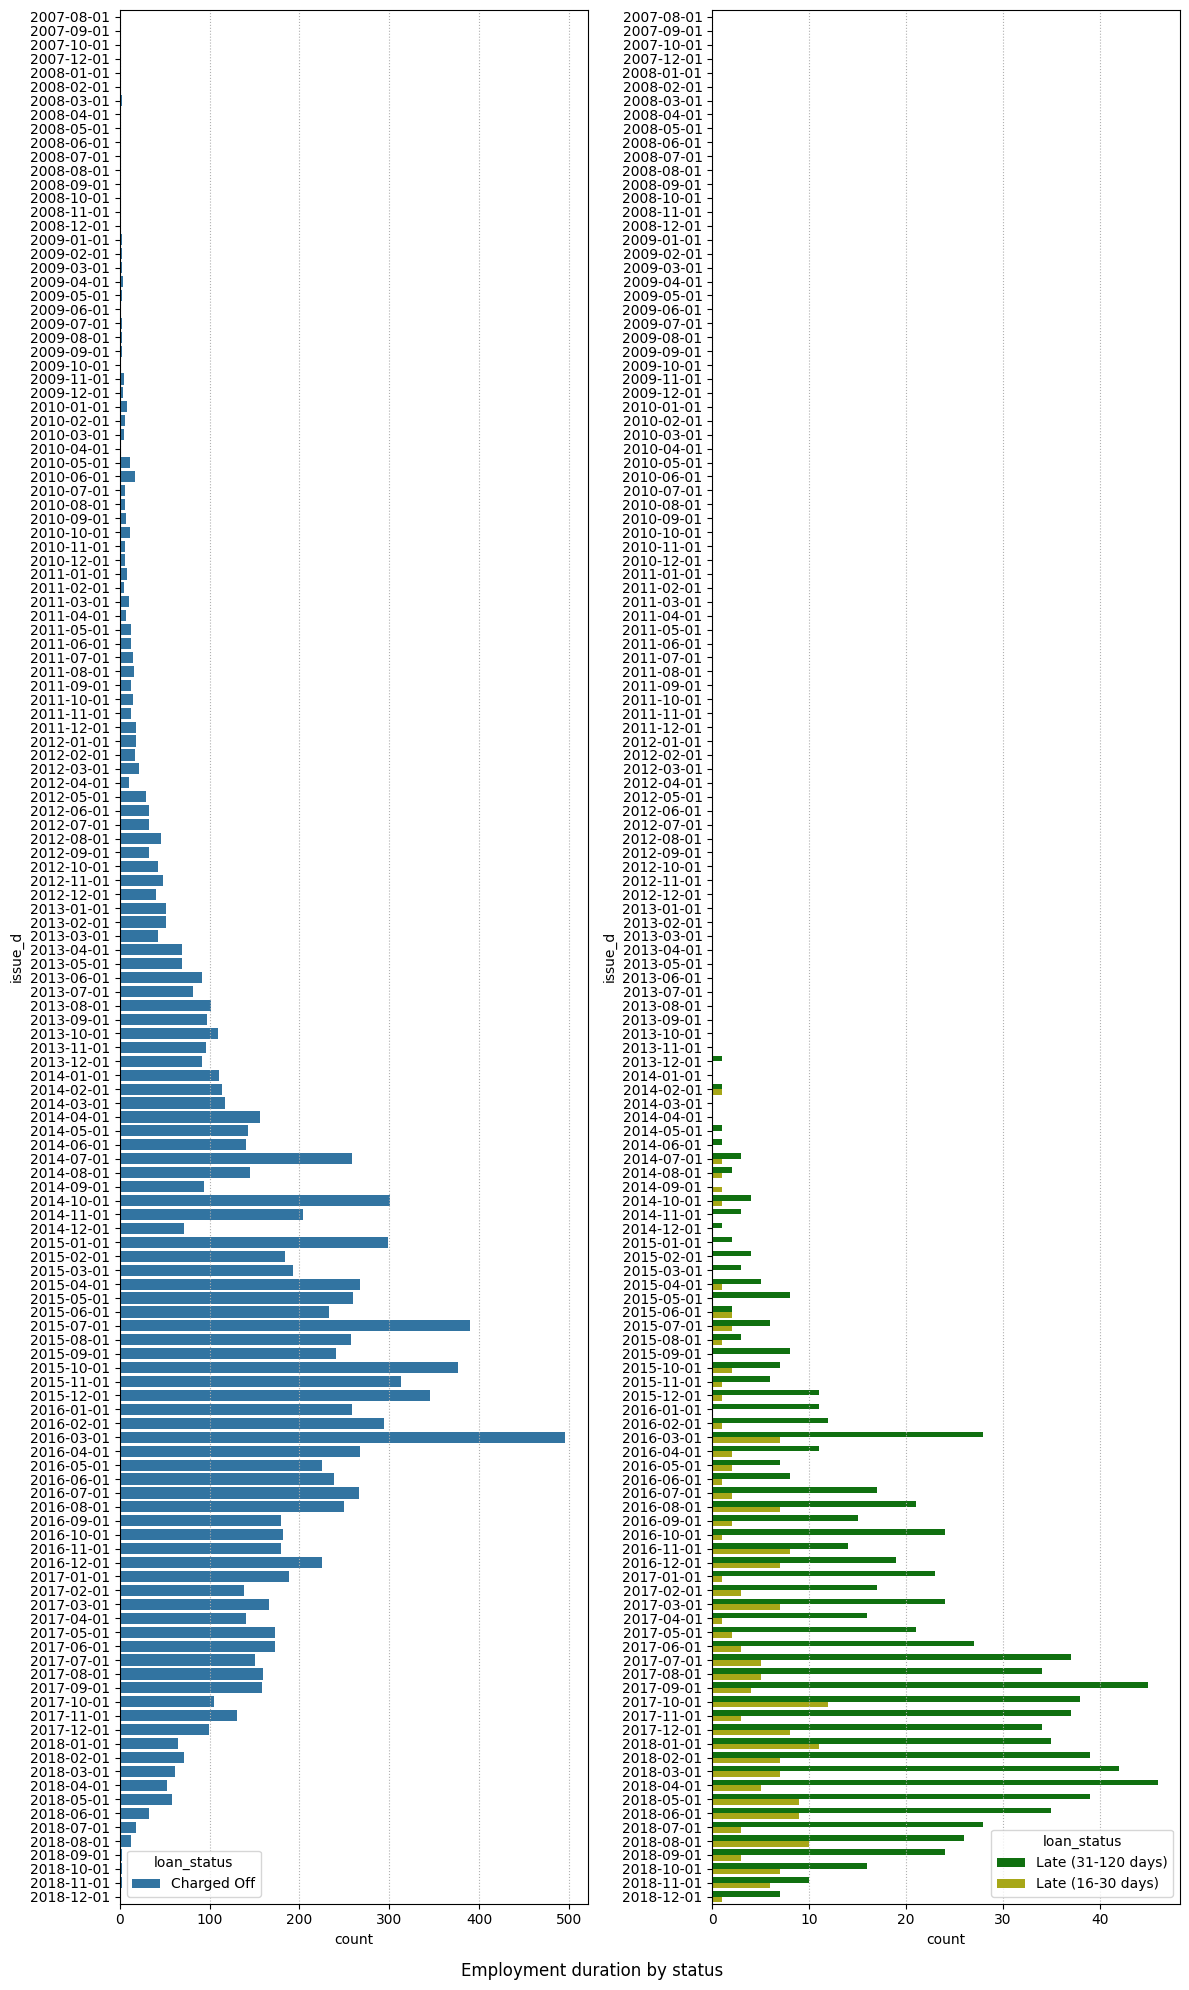

In [18]:
#fig_id=4

fig, ax = plt.subplots(1,2, figsize=(12, 20))
fig = sns.countplot(data=data[data['loan_status']=='Charged Off'], y='issue_d', hue='loan_status', ax=ax[0], order=new_order) #, palette=['b','r']width=0.5,
ax[0].xaxis.grid(linestyle=':')
#ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)

fig = sns.countplot(data=temp2, y='issue_d', hue='loan_status',  ax=ax[1], palette=['g','y'], order=new_order) #width=0.5,
ax[1].xaxis.grid(linestyle=':')
#ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)

plt.suptitle(f'Employment duration by status ', y=-0.0) #Fig.{fig_id} - 
#ax.set_yscale('log');
plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

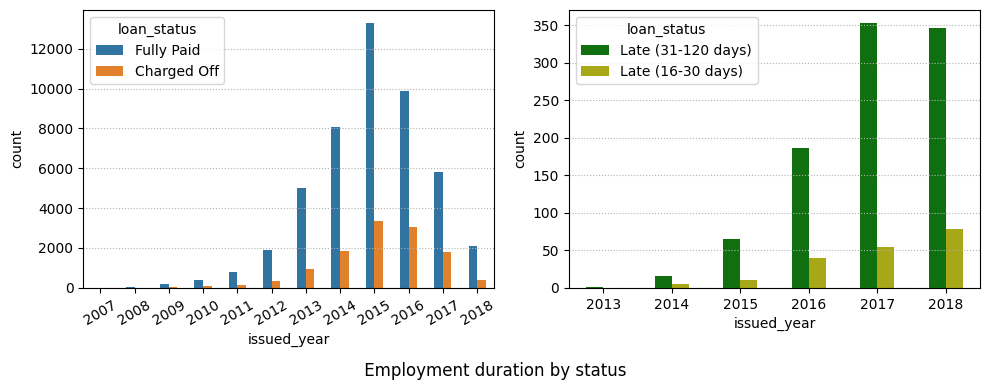

In [19]:
#fig_id=4

fig, ax = plt.subplots(1,2, figsize=(10, 4))
fig = sns.countplot(data=temp1, x='issued_year', hue='loan_status', width=0.5, ax=ax[0]) #, palette=['b','r']
ax[0].yaxis.grid(linestyle=':')
#ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)
ax[0].tick_params(axis='x', rotation=30)
               
fig = sns.countplot(data=temp2, x='issued_year', hue='loan_status', width=0.5, ax=ax[1], palette=['g','y'])
ax[1].yaxis.grid(linestyle=':')
#ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)

plt.suptitle(f' Employment duration by status ', y=-0.0) #Fig.{fig_id}
#ax.set_yscale('log');
plt.tight_layout()

In [20]:
# repaid = data[data['loan_status']=='Fully Paid'].groupby(['issued_year'])['loan_status'].count()
# default = data[data['loan_status']=='Charged Off'].groupby(['issued_year'])['loan_status'].count()
# overdue = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')].groupby(['issued_year'])['loan_status'].count()
# applications = data.groupby(['issued_year'])['loan_status'].count()

# #default_rates = default / repaid
# #overdue_rate = overdue / repaid

# rates = pd.DataFrame({
#     'default rate': default / repaid *100, 
#     'overdue rate': overdue / repaid*100
# })
# app =  pd.DataFrame({'applications': applications})

# plot_counter = 7
# fig, ax = plt.subplots(figsize=(6, 4))

# sns.lineplot(rates, markers='o')
# ax.set_xlabel('Years')
# ax.set_ylabel('Percents')
# ax.yaxis.grid(linestyle=':')
# #ax.set_yscale('log')

# ax2 = ax.twinx() 
# ax2 = sns.lineplot(applications, marker='^', color='red', label='applications ') #'-o' color='red',, size=35
# #a2.set_xlabel('Loan grade')
# ax2.set_ylabel('Annual number of applications')
# ax2.set_yscale('log')


# ax.set_title(f'Applications, default and overdue rates by issue year', y=-0.35, fontsize=13, loc='right') #Fig.{plot_counter} - 
# ax.legend(bbox_to_anchor=(0.7, .5))
# ax2.legend(bbox_to_anchor=(0.7, 0.3))
# plt.tight_layout()
# #plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

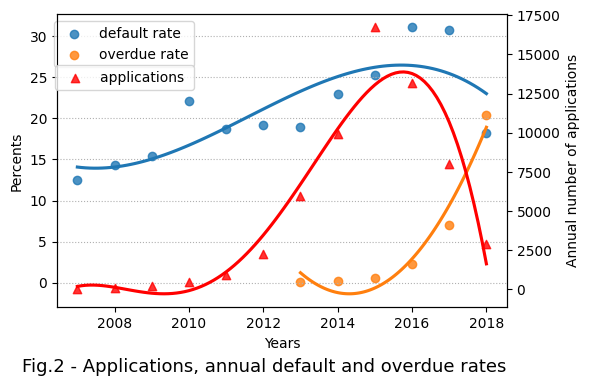

In [21]:
repaid = data[data['loan_status']=='Fully Paid'].groupby(['issued_year'])['loan_status'].count()
default = data[data['loan_status']=='Charged Off'].groupby(['issued_year'])['loan_status'].count()
overdue = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')].groupby(['issued_year'])['loan_status'].count()
applications = data.groupby(['issued_year'])['loan_status'].count()

#default_rates = default / repaid
#overdue_rate = overdue / repaid

rates = pd.DataFrame({
    'default rate': default / repaid *100, 
    'overdue rate': overdue / repaid*100
})
app =  pd.DataFrame({'applications': applications})

plot_counter = 2
fig, ax = plt.subplots(figsize=(6, 4))

sns.regplot(rates, x=rates.index, y='default rate', order=3, ci=None, label='default rate') #, markers='o'
sns.regplot(rates, x=rates.index, y='overdue rate', order=2, ci=None, label='overdue rate')
ax.set_xlabel('Years')
ax.set_ylabel('Percents')
ax.yaxis.grid(linestyle=':')

ax2 = ax.twinx() 
ax2 = sns.regplot(app, x=app.index, y=app.values, order=4, ci=None, marker='^', color='red', label='applications ') #'-o' color='red',, size=35
ax2.set_ylabel('Annual number of applications')
#ax2.set_yscale('log')
ax.set_title(f'Fig.{plot_counter} - Applications, annual default and overdue rates', y=-0.25, fontsize=13, loc='right')
ax.legend(bbox_to_anchor=(.32, 1))
ax2.legend(bbox_to_anchor=(0.32, 0.85))
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [22]:
# delete unnesessairy feature
data.drop(['issue_d'],axis=1, inplace=True)

### grade and sub_grade

In [23]:
get_descr('grade')
get_descr('sub_grade')

LC assigned loan grade
LC assigned loan subgrade


In [24]:
data['grade'].value_counts(True)

B    0.288326
C    0.286150
A    0.169398
D    0.153124
E    0.071525
F    0.024287
G    0.007189
Name: grade, dtype: float64

In [25]:
data[['grade','sub_grade']]

,grade,sub_grade
1,C,C1
2,A,A3
3,B,B4
5,B,B2
...,...,...
99994,B,B3
99996,D,D3
99997,C,C2
99999,A,A2


In [26]:
# comparisson of 2 features
data['grade'].compare(data['sub_grade'].astype(str).str[0])

,self,other


> Grades matches with 1st letters of subgrades 

Number of unique categories:  35


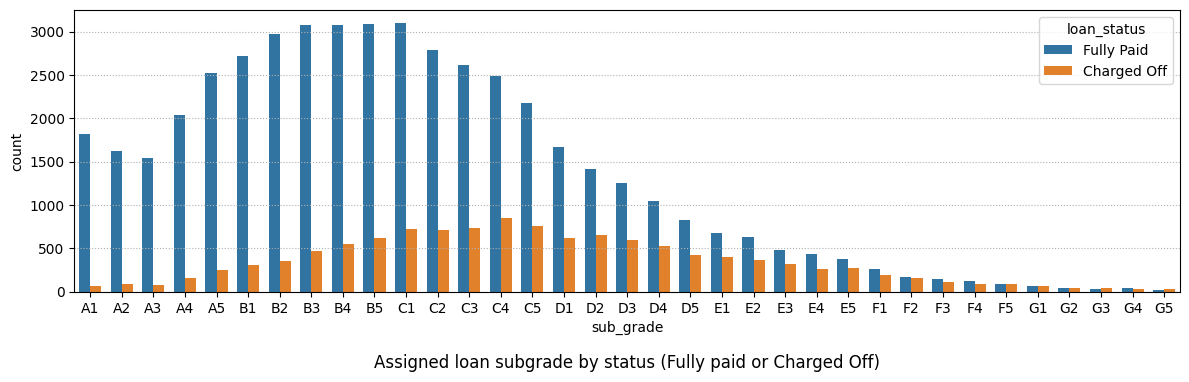

In [27]:
new_order = list(np.sort(data['sub_grade'].unique()))
print('Number of unique categories: ', len(new_order))
temp = data[(data['loan_status']=='Fully Paid') | (data['loan_status']=='Charged Off')]
fig_id=2

fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.countplot(data=temp, x='sub_grade', hue='loan_status', width=0.7, order=new_order)
ax.yaxis.grid(linestyle=':')
ax.set_title(f'Assigned loan subgrade by status (Fully paid or Charged Off)', y=-0.3);
#ax.set_yscale('log');
plt.tight_layout()

Number of unique categories:  7


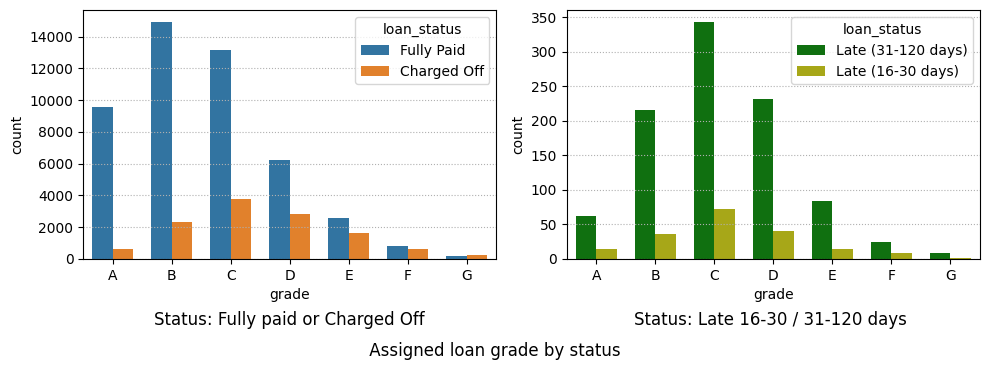

In [28]:
new_order = list(np.sort(data['grade'].unique()))
print('Number of unique categories: ', len(new_order))
temp1 = data[(data['loan_status']=='Fully Paid') | (data['loan_status']=='Charged Off')]
temp2 = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')]
fig_id=2

fig, ax = plt.subplots(1,2, figsize=(10, 4))
sns.countplot(data=temp1, x='grade', hue='loan_status', width=0.7, ax=ax[0], order=new_order) #, palette=['b','r']
ax[0].yaxis.grid(linestyle=':')
ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)

ax[1] = sns.countplot(data=temp2, x='grade', hue='loan_status', width=0.7, order=new_order, palette=['g','y'])
ax[1].yaxis.grid(linestyle=':')
ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)
plot_counter = 2
plt.suptitle(f' Assigned loan grade by status ', y=0.05) #Fig.{plot_counter} -
#ax.set_yscale('log');
plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

In [29]:
mask_paid = data['loan_status']=='Fully Paid'
mask_charged = data['loan_status']=='Charged Off'
mask_overdue = (data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')

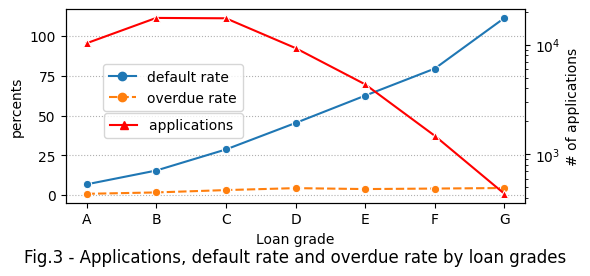

In [30]:
repaid =  data[mask_paid].groupby(['grade'])['loan_status'].count()
default = data[mask_charged].groupby(['grade'])['loan_status'].count()
overdue = data[mask_overdue].groupby(['grade'])['loan_status'].count()
applications = data.groupby(['grade'])['loan_status'].count()

#default_rates = default / repaid
#overdue_rate = overdue / repaid

rates = pd.DataFrame({
    'default rate': default / repaid *100, 
    'overdue rate': overdue / repaid*100
})
app =  pd.DataFrame({'applications ': applications})

plot_counter = 3
fig, ax = plt.subplots(1,1, figsize=(6, 3))

sns.lineplot(rates, markers='o')
ax.set_xlabel('Loan grade')
ax.set_ylabel('percents')
#ax.set_yscale('log')
ax.yaxis.grid(linestyle=':')
#plt.title('Title', fontsize=17,  position=(0.5,0.85))

ax2 = ax.twinx() 
ax2 = sns.lineplot(app, markers='^', palette=['r'])
#a2.set_xlabel('Loan grade')
ax2.set_ylabel('# of applications')
ax2.set_yscale('log')

#ax.yaxis.grid(linestyle=':')
ax.set_title(f'Fig.{plot_counter} - Applications, default rate and overdue rate by loan grades', y=-0.35)

ax.legend(bbox_to_anchor=(0.4, .75))
ax2.legend(bbox_to_anchor=(0.4, 0.5));
plt.tight_layout();
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

> Although the 'sub_grade' feature categorises loans more precise than 'grade', the latter feature represents the trend more consizely, and, therefore, histograms will be shorter. 

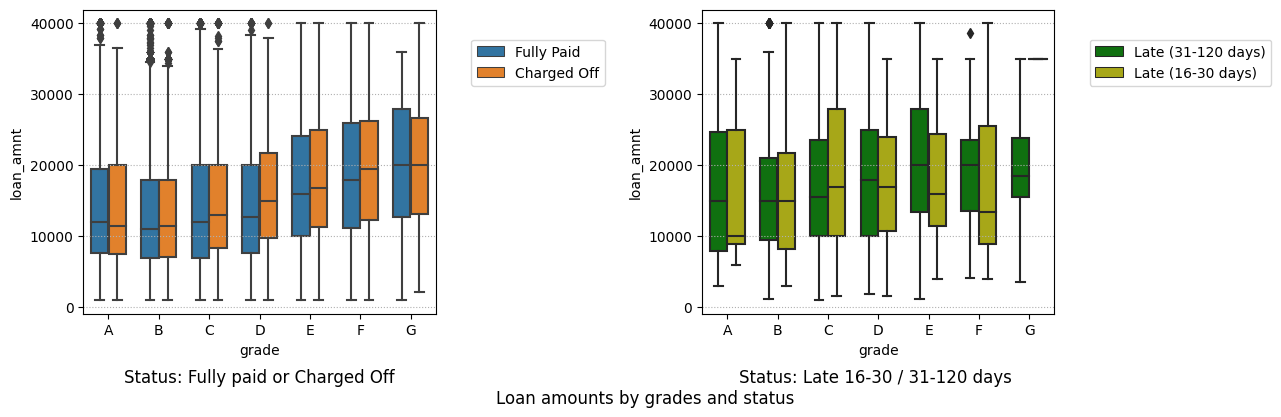

In [31]:
fig, ax = plt.subplots(1,2, figsize=(13, 4.5))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(data=temp1, x='grade', y='loan_amnt', hue='loan_status', width=0.7, ax=ax[0], order=new_order) #, palette=['b','r']
ax[0].yaxis.grid(linestyle=':')
ax[0].set_title('Status: Fully paid or Charged Off', y=-0.25)
major_ticks = np.linspace(0, 40000, 5)
ax[0].set_yticks(major_ticks)

ax[0].legend(loc=(1.1,0.75))

ax[1] = sns.boxplot(data=temp2, x='grade', y='loan_amnt', hue='loan_status', width=0.7, order=new_order, palette=['g','y'])
ax[1].yaxis.grid(linestyle=':')
ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.25)
ax[1].set_yticks(major_ticks)
ax[1].legend(loc=(1.1,0.75))

#plot_counter = 3
plt.suptitle(f'Loan amounts by grades and status', y=0.05)#Fig.{plot_counter} - 
plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [32]:
data[data['delinq_amnt']>0]['delinq_amnt'].agg(['sum', 'count'])

sum      864253.0
count       209.0
Name: delinq_amnt, dtype: float64

In [33]:
data[data['total_pymnt']>0]['total_pymnt'].agg(['count']) #'sum', 

count    60613
Name: total_pymnt, dtype: int64

In [34]:
#data.drop('grade', axis=1, inplace=True)

Customers with lower loan grade repay loans more often in contrast to those with higher loan grades.

### term

In [35]:
data['term'].value_counts(True)

 36 months    0.754229
 60 months    0.245771
Name: term, dtype: float64

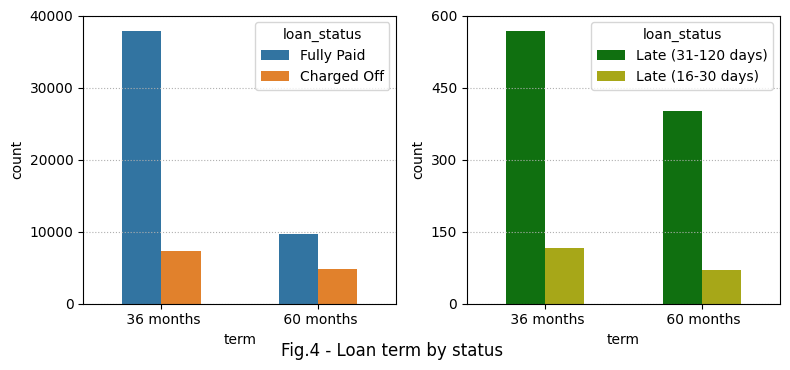

In [36]:
plot_counter = 4

fig, ax = plt.subplots(1,2, figsize=(8, 4))
fig = sns.countplot(data=temp1, x='term', hue='loan_status', width=0.5, ax=ax[0])  

ax[0].yaxis.grid(linestyle=':')
#ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)
major_ticks = np.linspace(0, 40000, 5)
ax[0].set_yticks(major_ticks)

fig = sns.countplot(data=temp2, x='term', hue='loan_status', width=0.5, ax=ax[1], palette=['g','y'])
ax[1].yaxis.grid(linestyle=':')
#ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)
major_ticks = np.linspace(0, 600, 5)
ax[1].set_yticks(major_ticks)

plt.suptitle(f'Fig.{plot_counter} - Loan term by status ', y=0.05)
#ax.set_yscale('log');
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

In [37]:
# repaid = data[data['loan_status']=='Fully Paid'].groupby(['term'])['loan_status'].count()
# default = data[data['loan_status']=='Charged Off'].groupby(['term'])['loan_status'].count()
# overdue = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')].groupby(['term'])['loan_status'].count()
# applications = data.groupby(['term'])['loan_status'].count()

# #default_rates = default / repaid
# #overdue_rate = overdue / repaid

# rates = pd.DataFrame({
#     'default rate': default / repaid *100, 
#     'overdue rate': overdue / repaid*100
# })
# app =  pd.DataFrame({'applications': applications})

# plot_counter = 4
# fig, ax = plt.subplots(figsize=(6, 4))

# sns.regplot(rates, x=rates.index, y='default rate', order=3, ci=None, label='default rate') #, markers='o'
# sns.regplot(rates, x=rates.index, y='overdue rate', order=2, ci=None, label='overdue rate')
# ax.set_xlabel('Years')
# ax.set_ylabel('Percents')
# ax.yaxis.grid(linestyle=':')

# ax2 = ax.twinx() 
# ax2 = sns.regplot(app, x=app.index, y=app.values, order=4, ci=None, marker='^', color='red', label='applications ') #'-o' color='red',, size=35
# ax2.set_ylabel('Annual number of applications')
# #ax2.set_yscale('log')
# ax.set_title(f'Fig.{plot_counter} - Applications, annual default and overdue rates', y=-0.25, fontsize=13, loc='right')
# ax.legend(bbox_to_anchor=(.32, 1))
# ax2.legend(bbox_to_anchor=(0.32, 0.85))
# plt.tight_layout()

# plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [38]:
data['term'] = data['term'].replace({' 36 months': '36_m', ' 60 months': '60_m'})

Customers fully pay short-term loans more ofter, than long-term. 

### emp_length

In [39]:
get_descr('emp_length')
data['emp_length']

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 


1              NaN
2          4 years
3        10+ years
5        10+ years
           ...    
99994    10+ years
99996    10+ years
99997      3 years
99999      4 years
Name: emp_length, Length: 60650, dtype: object

In [40]:
data['emp_length'] = data['emp_length'].apply(lambda x: str(x).replace('+ years', '')\
    .replace(' years', '').replace('< 1 year', '0')).replace('1 year', '1').replace('nan','-1').astype('int')
data['emp_length'].replace(-1, 0, inplace=True)

In [41]:
data.isna().sum()

loan_amnt                0
delinq_amnt              0
total_rec_prncp          0
total_rec_int            0
                        ..
pub_rec_bankruptcies    31
hardship_flag            0
funded_amnt              0
issued_year              0
Length: 37, dtype: int64

In [42]:
# new_order = np.array(np.sort(temp1['emp_length'].unique()))
# print('Number of unique categories: ', len(sub_grade))
# np.trim_zeros(new_order,trim='fb')
temp1 = data[(data['loan_status']=='Fully Paid') | (data['loan_status']=='Charged Off')]
temp2 = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')]

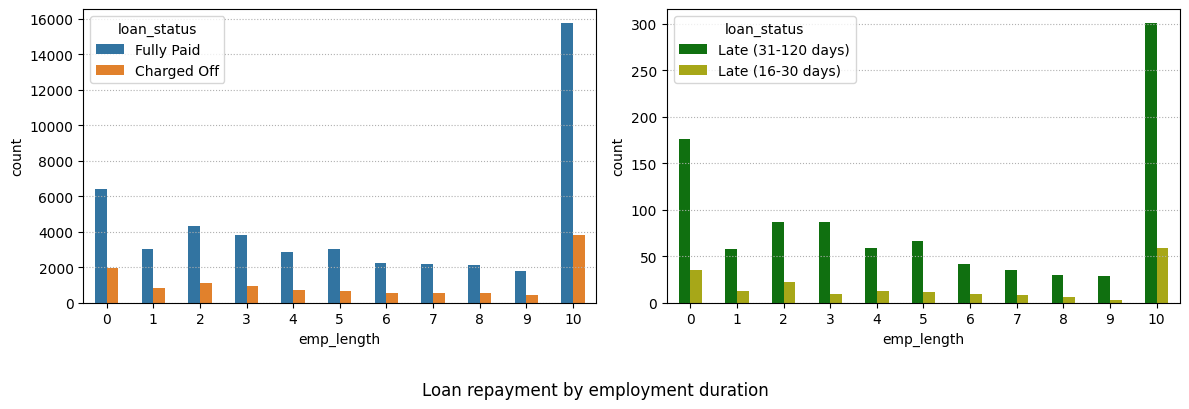

In [43]:
plot_counter = 5

fig, ax = plt.subplots(1,2, figsize=(12, 4))
fig = sns.countplot(data=temp1, x='emp_length', hue='loan_status', width=0.5, ax=ax[0])
ax[0].yaxis.grid(linestyle=':')
#ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)

fig = sns.countplot(data=temp2, x='emp_length', hue='loan_status', width=0.5, ax=ax[1], palette=['g','y'])
ax[1].yaxis.grid(linestyle=':')
#ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)

plt.suptitle(f'Loan repayment by employment duration', y=-0.05) #Fig.{plot_counter} - 
#ax.set_yscale('log');
plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

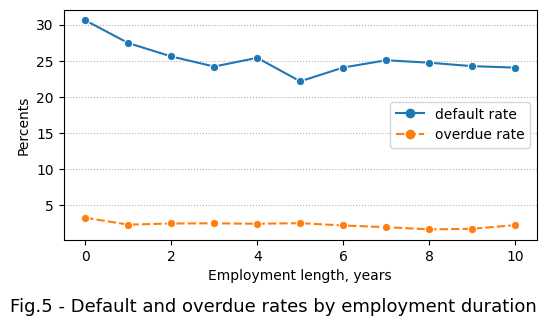

In [44]:
repaid = data[data['loan_status']=='Fully Paid'].groupby(['emp_length'])['loan_status'].count()
default = temp1[temp1['loan_status']=='Charged Off'].groupby(['emp_length'])['loan_status'].count()
overdue = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')].groupby(['emp_length'])['loan_status'].count()

#default_rates = default / repaid
#overdue_rate = overdue / repaid

rates = pd.DataFrame({
    'default rate': default / repaid *100, 
    'overdue rate': overdue / repaid*100
})

plot_counter = 5
fig, ax = plt.subplots(1,1, figsize=(5.5, 3.5))

plt.subplots_adjust(#left=0.1,
                    #bottom=0.2,
                    right=0.9,
                    #top=0.9,
                    wspace=0.2,
                    #hspace=0.3
                    )
sns.lineplot(rates, markers='o')
ax.set_xlabel('Employment length, years')
ax.set_ylabel('Percents')
ax.yaxis.grid(linestyle=':')
#ax.set_yscale('log')

ax.set_title(f'Fig.{plot_counter} - Default and overdue rates by employment duration', y=-0.35, fontsize=13, loc='right')
plt.tight_layout()
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

### emp_title

In [45]:
get_descr('emp_title')
data['emp_title'].nunique()

The job title supplied by the Borrower when applying for the loan. Employer Title replaces Employer Name for all loans listed after 9/23/2013


28721

In [46]:
data['emp_title'] = data['emp_title'].apply(str).str.strip()

In [47]:
#data['emp_title'] = data['emp_title'].astype('string')
#data['emp_title'] = data['emp_title'].str.replace(',', '')
#data['emp_title'] = pd.to_numeric(data['emp_title'], errors='coerce')

In [48]:
#  lower case
#data['emp_title'] = data['emp_title'].apply(lambda x: x.lower().replace('/',' '))

In [49]:
# def get_professions(arg:str)->str:
#     """Categorization of popular professions

#     Args:
#         arg (str): строка датафрейма

#     Returns:
#         _type_: _description_
#     """    
    
#     arg = arg.lower()
    
#     management = ['foreman','shop foreman', 'team leader','chef','maintenance supervisor','team lead','administration', 'deputy', 'forman', 'superviser','administrative', 'admin','group leader','manger', 'crew leader', 'mgr','payroll', 'superintendant', 'superintendent']
#     executives = ['general manager', 'vice president','director','account executive', 'sales executive','ceo', 'partner', 'president','senior vice president', 'vp','svp','cfo','cto', 'gm', 'coo','co-owner', 'vp of operations', 'vp operations', 'senior associate', 'co-founder', 'founder']
#     #engineers = ['engineer','software engineer']

#     employees = ['nurse', 'registered nurse', 'rn', 'lpn', 'cna', 'nursing','social worker', 'bartender', 'cook', 'machinist', 'bookkeeper','machine operator','electrician', 'operator', 'carpenter', 'pharmacist','clerk','cashier','laborer','receptionist','instructor','welder','dispatcher','bus operator', 'custodian', 'underwriter', 'realtor','conductor','mechanic','firefighter','maintenance','server','production','flight attendant', 'designer','security', 'lvn','buyer', 'agent','service tech','plumber','warehouse', 'stylist','hairstylist', 'teller', 'pastor','senior pastor','clerical','courier', 'logistics', 'shipping','transportation','porter', 'material handler','labor','painter','lineman','assembly', 'contractor','data entry','housekeeping','office','librarian','sous chef', 'nanny', 'installer','warehouse worker','assembler','table games dealer', 'adjuster', 'firefighter paramedic','millwright','baker','merchandiser','doorman','barista']
    
#     skilled_laborers = ['engineer', 'officer','administrative assistant', 'administrator','paralegal', 'attorney', 'counselor','cse','supervisor', 'csr','pilot','ramp agent', 'captain','investigator','service advisor', 'human resources','at&t','recruiter', 'hr','housekeeper', \
#         # law
#         'lawyer', 'auditor', 
#         #IT
#         'it', 'programmer','software developer','it specialist','web developer','coder',
#         #finance
#         'banker', 'bank of america','accounts payable','medical biller','controller', 'accounting', 'personal banker','broker','business development','loan processor','financial advisor','payroll specialist','jp morgan chase','stocker','relationship banker','estimator','mortgage banker','finance','biller','accounts receivable','cpa','cma','billing','account representative', 'wells fargo', 'northrop grumman',
#         # education
#         'professor','teacher', 'educator', 'faculty','dean','paraprofessional','lecturer',
#         #security
#         'security guard','lieutenant','united states air force','sergeant', 'inspector','staff sergeant', 'deputy sheriff','border patrol agent', 'detective','special agent','us army','major', 'department of defense','lockheed martin','us air force','us navy','detective','u.s. army',
#         # sales
#         'sales rep','sales', 'sales representative','dealer','purchasing','collector', 'purchasing agent', \
#         # medics
#         'physician', 'dental hygienist','pharmacy tech', 'paramedic', 'caregiver','dentist','phlebotomist', 'optician','psychologist','speech language pathologist','resident physician', 'veterinarian','respiratory therapist', 'care giver','kaiser permanente','radiographer', 'clinician', \
#         # other
#         'advisor','trainer','claims adjuster', 'principal', 'associate','graphic designer','marketing', 'quality control','lead','chemist','specialist','scientist','operations',
#         ]
#     #sales = []
    

#     if arg in executives or 'owner' in arg or 'president' in arg: 
#         return 'executive' 
    
#     elif arg in management or 'manager' in arg or 'supervisor' in arg or 'executive' in arg or 'coordinator' in arg or 'lead' in arg or 'foreman' in arg or 'forman' in arg or 'head' in arg or 'supervisior' in arg or 'director' in arg or 'mgr' in arg or 'management' in arg or 'managing' in arg:   
#         return 'manager'
    
#     elif arg in skilled_laborers or 'consultant' in arg or 'analyst' in arg or 'officer' in arg or 'engineer' in arg or 'accountant' in arg or 'bank' in arg or 'administrator' in arg or 'counselor' in arg or 'insurance' in arg or 'police' in arg or 'it' in arg or 'professor' in arg or 'teacher' in arg or 'specialist' in arg or 'programmer' in arg or 'scientist' in arg or 'developer' in arg or 'coder' in arg or 'psychologist' in arg or 'therapist' in arg or 'pathologist' in arg or 'emt' in arg or 'agent' in arg or 'officer' in arg or 'attorney' in arg or 'paralegal' in arg or 'minister' in arg or 'research' in arg or 'buyer' in arg or 'billing' in arg or 'associate' in arg or 'planner' in arg or 'representative' in arg or 'professional' in arg or 'broker' in arg or 'trainer' in arg or 'admin' in arg:
#         return 'skilled_laborer'
    
#     elif arg in employees or 'technician' in arg or 'operator' in arg or 'assistant' in arg or 'nurse' in arg or 'tech' in arg or 'sales' in arg  or 'service' in arg or 'controller' in arg or 'mail' in arg or 'ups' in arg or 'usps' in arg or 'post' in arg or 'staff' in arg or 'worker' in arg or 'clerk' in arg or 'mechanic' in arg or 'carrier' in arg or 'machinist' in arg or 'desk' in arg or 'manufacturing' in arg or 'driver' in arg or 'handler' in arg or 'secretary' in arg or 'dispatcher' in arg or 'electrician' in arg:
#         return 'employee'
   
#     else:
#         return arg #'other'

In [50]:
data['emp_title'] = data['emp_title'].apply(get_professions)
data['emp_title'].value_counts(True) #.index

skilled_laborer    0.282308
other              0.249563
manager            0.234048
employee           0.187519
executive          0.046562
Name: emp_title, dtype: float64

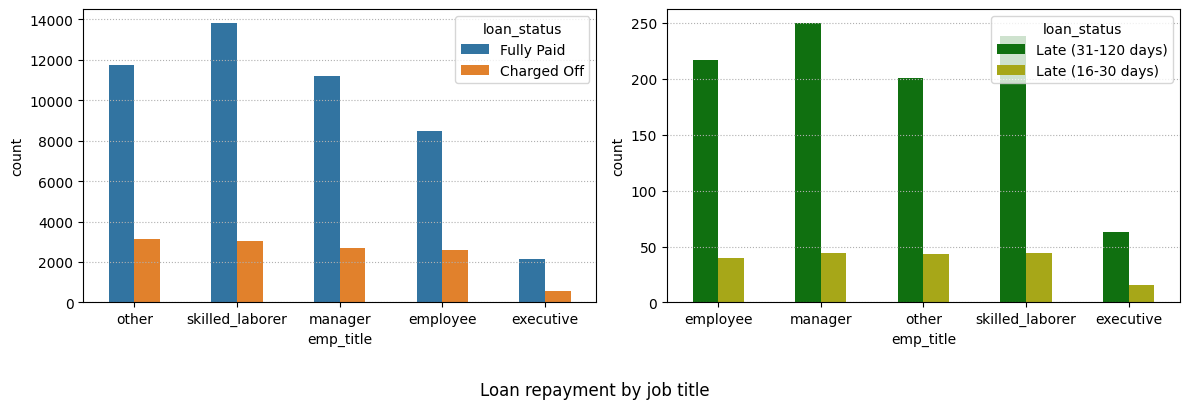

In [51]:
plot_counter = 6

temp1 = data[(data['loan_status']=='Fully Paid') | (data['loan_status']=='Charged Off')]
temp2 = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')]

fig, ax = plt.subplots(1,2, figsize=(12, 4))
fig = sns.countplot(data=temp1, x='emp_title', hue='loan_status', width=0.5, ax=ax[0]) #, palette=['b','r']
ax[0].yaxis.grid(linestyle=':')
#ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)

fig = sns.countplot(data=temp2, x='emp_title', hue='loan_status', width=0.5, ax=ax[1], palette=['g','y'])
ax[1].yaxis.grid(linestyle=':')
#ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)

plt.suptitle(f'Loan repayment by job title', y=-0.05) #Fig.{plot_counter} - 
#ax.set_yscale('log');
plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

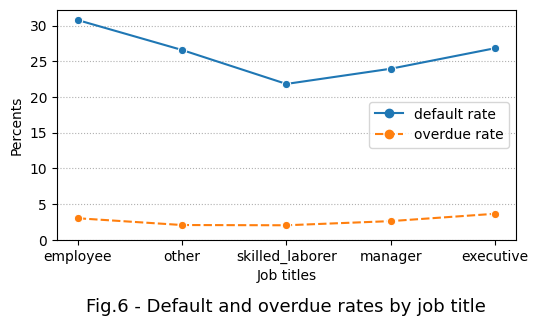

In [52]:
repaid = data[data['loan_status']=='Fully Paid'].groupby(['emp_title'])['loan_status'].count()
default = temp1[temp1['loan_status']=='Charged Off'].groupby(['emp_title'])['loan_status'].count()
overdue = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')].groupby(['emp_title'])['loan_status'].count()

#default_rates = default / repaid
#overdue_rate = overdue / repaid

rates = pd.DataFrame({
    'default rate': default / repaid *100, 
    'overdue rate': overdue / repaid*100
}).reindex(['employee', 'other', 'skilled_laborer', 'manager', 'executive'])


plot_counter = 6
fig, ax = plt.subplots(1,1, figsize=(5.5, 3.5))
sns.lineplot(rates, markers='o')
ax.set_xlabel('Job titles')
ax.set_ylabel('Percents')
ax.set_title(f'Fig.{plot_counter} - Default and overdue rates by job title', y=-0.35, fontsize=13) #, loc='right'
#ax.set_yscale('log')

ax.yaxis.grid(linestyle=':')
major_ticks = np.linspace(0, 30, 7)
ax.set_yticks(major_ticks)
plt.tight_layout();
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

### home_ownership

In [53]:
data['home_ownership'].value_counts(True)

MORTGAGE    0.492580
RENT        0.398021
OWN         0.108969
ANY         0.000231
OTHER       0.000115
NONE        0.000082
Name: home_ownership, dtype: float64

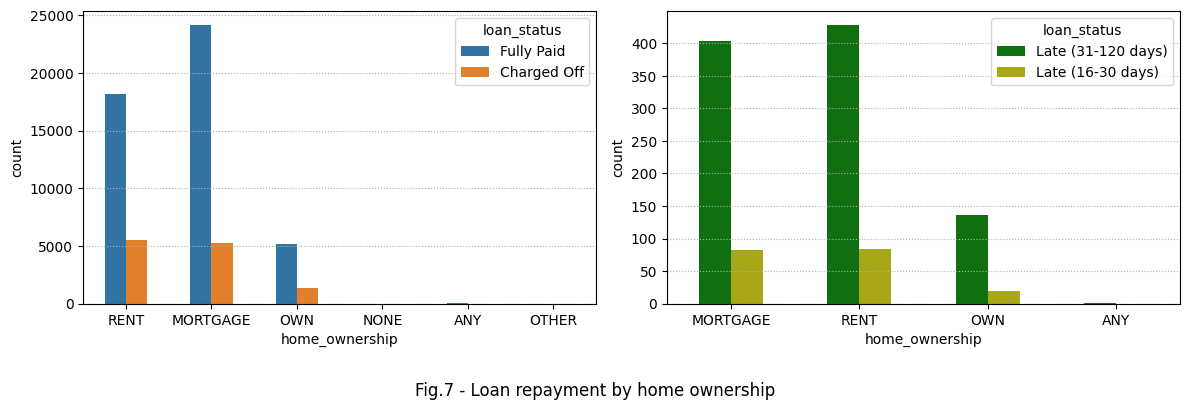

In [54]:
plot_counter = 7
fig, ax = plt.subplots(1,2, figsize=(12, 4))
fig = sns.countplot(data=temp1, x='home_ownership', hue='loan_status', width=0.5, ax=ax[0]) #, palette=['b','r']
ax[0].yaxis.grid(linestyle=':')
#ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)

fig = sns.countplot(data=temp2, x='home_ownership', hue='loan_status', width=0.5, ax=ax[1], palette=['g','y'])
ax[1].yaxis.grid(linestyle=':')
#ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)

plt.suptitle(f'Fig.{plot_counter} - Loan repayment by home ownership', y=-0.05)
#ax.set_yscale('log');
plt.tight_layout()

### annual_inc

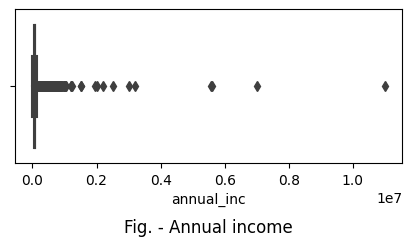

In [55]:
fig, ax = plt.subplots(figsize=(5, 2)) 
sns.boxplot(data, x='annual_inc')
#plt.tight_layout()
ax.set_title('Fig. - Annual income', y=-0.5);

In [56]:
# Logarythm of the feature
data['annual_inc_log'] = data['annual_inc'].apply(lambda x: np.log(x) if x > 0  else 0)
data['annual_inc_log'].describe()

count    60650.000000
mean        11.079131
std          0.578791
min          0.000000
25%         10.725468
50%         11.082143
75%         11.407565
max         16.213333
Name: annual_inc_log, dtype: float64

In [57]:
def get_sigma_limits(data: pd.DataFrame, features:list, sigma_factor=3):
    """Returns upper limit 

    Args:
        feature (pd.DataFrame): Feature to process
        limit
    """    
    for i, name in enumerate(features):
        mean = data[name].mean()
        std = data[name].std() 
        upper_limit = round(mean + sigma_factor* std)
        lower_limit = round(mean - sigma_factor* std)
        #print(f'Upper limit for {name} is: ', upper_limit)
        
        n_outliers = len(data[(data['annual_inc_log'] < lower_limit) | (data['annual_inc_log'] > upper_limit)].index)
        print('number of outliers: ', n_outliers)
        lower_limit = np.where(lower_limit>0, lower_limit,0)#.astype(int)
        
        limits = {'upper_limit':upper_limit,
                  'lower_limit':lower_limit,
                  'n_outliers': n_outliers}
        
    return limits

limits = get_sigma_limits(data, ['annual_inc'])
limits

number of outliers:  0


{'upper_limit': 327447, 'lower_limit': array(0), 'n_outliers': 0}

In [58]:
data.groupby('loan_status')['annual_inc'].agg(['median','mean']).round()

,median,mean
loan_status,,
Charged Off,60000.0,70830.0
Fully Paid,65000.0,77749.0
Late (16-30 days),75000.0,83646.0
Late (31-120 days),65000.0,76087.0


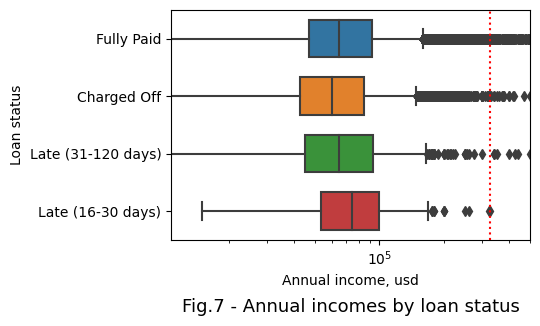

In [59]:
fig, ax = plt.subplots(1,1, figsize=(5.5, 3.5))
fig = sns.boxplot(data=data, x='annual_inc', y='loan_status', width=.65)
# Обозначение границы областью
# fig.add_vrect(
#     limits['lower_limit'], limits['upper_limit'],
#     fillcolor="LightSalmon", opacity=0.5,
#     layer="below", line_width=0,
#     name="Boundaries of z-method"
# )
ax.axvline(limits['lower_limit'], color='r', ls=':')
ax.axvline(limits['upper_limit'], color='r', ls=':')


plot_counter = 7
 
ax.set_xlabel('Annual income, usd')
ax.set_ylabel('Loan status')
ax.set_title(f'Fig.{plot_counter} - Annual incomes by loan status', y=-0.35, fontsize=13) #, loc='right'
ax.set_xscale('log')
 
ax.set_xlim([0,500000])
plt.tight_layout()
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [60]:
data.drop(['annual_inc'], axis=1, inplace=True)

### verification_status

In [61]:
get_descr('verification_status')

Indicates if income was verified by LC, not verified, or if the income source was verified


In [62]:
data['verification_status'].value_counts(True)

Source Verified    0.389810
Verified           0.309151
Not Verified       0.301039
Name: verification_status, dtype: float64

### pymnt_plan

In [63]:
get_descr('pymnt_plan')

Indicates if a payment plan has been put in place for the loan


In [64]:
data['pymnt_plan'].value_counts()

n    60618
y       32
Name: pymnt_plan, dtype: int64

### purpose

In [65]:
new_var = get_descr('purpose')
new_var

A category provided by the borrower for the loan request. 


In [66]:
data['purpose'].value_counts()

debt_consolidation    35294
credit_card           13357
home_improvement       3801
other                  3500
                      ...  
house                   376
wedding                  95
renewable_energy         27
educational               9
Name: purpose, Length: 14, dtype: int64

In [67]:
data['purpose'].value_counts().index

Index(['debt_consolidation', 'credit_card', 'home_improvement', 'other',
       'major_purchase', 'medical', 'small_business', 'car', 'moving',
       'vacation', 'house', 'wedding', 'renewable_energy', 'educational'],
      dtype='object')

### title

In [68]:
get_descr('title')

The loan title provided by the borrower


In [69]:
data['title'].value_counts().index

Index(['Debt consolidation', 'Credit card refinancing', 'Home improvement',
       'Other', 'Major purchase', 'Debt Consolidation', 'Medical expenses',
       'Business', 'Car financing', 'Moving and relocation',
       ...
       'Help me consolidate debt so I can get engaged', 'pay off loan',
       'Finanical Freedom', 'Debt Consolidation 2', 'Payoff Master Card',
       'Consolidating bad Credit Card Debt', 'End of Summer Trip',
       'consolidation of debts', 'education loan', 'Paint my House'],
      dtype='object', length=4223)

### 'installment'

In [70]:
get_descr('installment')

The monthly payment owed by the borrower if the loan originates.


<Axes: >

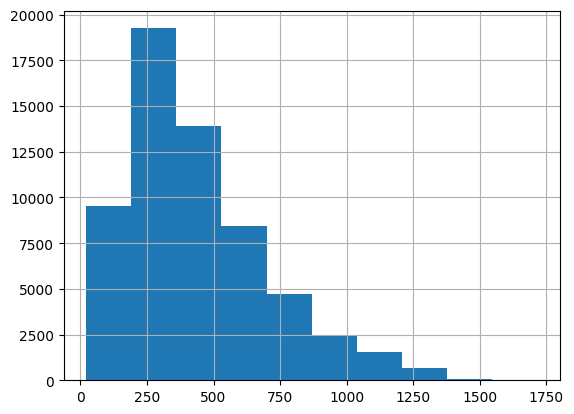

In [71]:
data['installment'].hist()

The feature 'installment' is redundant since it can be calculated using formula 
$$I = \frac {P \cdot i}{1 - (1 + i)^{-n}}$$

where:
* $I$ - installment value, dollars
* $i$ - monthly interest rate
* $n$ - number of months

In [72]:
data.drop('installment', axis=1, inplace=True)

### 

In [73]:
get_descr('issue_d')

The month which the loan was funded


### 'chargeoff_within_12_mths'

In [74]:
get_descr('chargeoff_within_12_mths')

Number of charge-offs within 12 months


In [75]:
data['chargeoff_within_12_mths'].unique() #.value_counts(True)

array([ 0.,  1.,  2., nan,  3.,  4.,  5.,  7.])

### 'funded_amnt'

In [76]:
get_descr('funded_amnt')

The total amount committed to that loan at that point in time.


### 'last_pymnt_d'

In [77]:
get_descr('last_pymnt_d')

Last month payment was received


In [78]:
data['last_pymnt_d'] = pd.to_datetime(data['last_pymnt_d'], errors='coerce').dt.date

In [79]:
data['last_pymnt_d'].value_counts(True)

2019-02-01    0.030092
2019-01-01    0.028375
2018-08-01    0.028243
2018-03-01    0.027912
                ...   
2009-04-01    0.000017
2008-04-01    0.000017
2009-01-01    0.000017
2008-06-01    0.000017
Name: last_pymnt_d, Length: 125, dtype: float64

In [80]:
temp1 = data[data['loan_status']=='Fully Paid']
temp2 = data[data['loan_status']=='Charged Off']
#temp2 = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')]

### 'delinq_amnt'

In [81]:
get_descr('delinq_amnt')

The past-due amount owed for the accounts on which the borrower is now delinquent.


In [82]:
#data['delinq_amnt'].hist()

In [83]:
#temp1['delinq_amnt'].sum()

In [84]:
#data['delinq_amnt']

## Select columns

In [85]:
data = data[['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length','loan_status','home_ownership','annual_inc_log','verification_status','pymnt_plan','purpose']]

In [86]:
# data = data[['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', \
#     'emp_title', 'emp_length','loan_status']]

In [87]:
# Delete less informative feature 'grade'
data.drop(['sub_grade'], axis=1, inplace=True)

data_copy = data.query("loan_status in ['Fully Paid', 'Charged Off']")

# Preprocessing

In [88]:
X, y = data_copy.drop('loan_status', axis=1), data_copy['loan_status']

In [89]:
num_features = [s for s in X.columns if X[s].dtypes != 'object']
сat_features = [s for s in X.columns if X[s].dtypes == 'object' or X[s].dtypes == 'category']
num_features

['loan_amnt', 'int_rate', 'emp_length', 'annual_inc_log']

In [90]:
X[num_features].head(1)

,loan_amnt,int_rate,emp_length,annual_inc_log
1,9600.0,12.99,0,9.994242


In [91]:
X[сat_features].head(1)

,term,grade,emp_title,home_ownership,verification_status,pymnt_plan,purpose
1,36_m,C,other,RENT,Verified,n,debt_consolidation


In [92]:
X.shape

(59494, 11)

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60650 entries, 1 to 99999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            60650 non-null  float64
 1   term                 60650 non-null  object 
 2   int_rate             60650 non-null  float64
 3   grade                60650 non-null  object 
 4   emp_title            60650 non-null  object 
 5   emp_length           60650 non-null  int32  
 6   loan_status          60650 non-null  object 
 7   home_ownership       60650 non-null  object 
 8   annual_inc_log       60650 non-null  float64
 9   verification_status  60650 non-null  object 
 10  pymnt_plan           60650 non-null  object 
 11  purpose              60650 non-null  object 
dtypes: float64(3), int32(1), object(8)
memory usage: 5.8+ MB


In [94]:
data[сat_features].head()

,term,grade,emp_title,home_ownership,verification_status,pymnt_plan,purpose
1,36_m,C,other,RENT,Verified,n,debt_consolidation
2,36_m,A,skilled_laborer,MORTGAGE,Not Verified,n,major_purchase
3,36_m,B,skilled_laborer,RENT,Not Verified,n,debt_consolidation
5,36_m,B,manager,MORTGAGE,Not Verified,n,debt_consolidation
6,36_m,B,other,RENT,Verified,n,debt_consolidation


In [95]:
scaler = StandardScaler() #RobustScaler()  #MinMaxScaler() #
X[num_features] = scaler.fit_transform(X[num_features].values)
X

,loan_amnt,term,int_rate,grade,...,annual_inc_log,verification_status,pymnt_plan,purpose
1,-0.549266,36_m,-0.065033,C,...,-1.879327,Verified,n,debt_consolidation
2,-1.190278,36_m,-1.381770,A,...,0.428815,Not Verified,n,major_purchase
3,-0.958484,36_m,-0.499076,B,...,-0.381240,Not Verified,n,debt_consolidation
5,0.641186,36_m,-0.795394,B,...,0.751608,Not Verified,n,debt_consolidation
...,...,...,...,...,...,...,...,...,...
99994,-1.510784,36_m,-0.739052,B,...,0.005329,Not Verified,n,home_improvement
99996,1.236411,36_m,0.769666,D,...,2.338971,Source Verified,n,debt_consolidation
99997,-0.503479,36_m,0.419092,C,...,-0.449185,Verified,n,debt_consolidation
99999,-0.274546,36_m,-1.442286,A,...,0.569084,Not Verified,n,credit_card


In [96]:
# Feature encoding
X = pd.get_dummies(X)
X.head()

,loan_amnt,int_rate,emp_length,annual_inc_log,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
1,-0.549266,-0.065033,-1.458535,-1.879327,...,0,0,0,0
2,-1.190278,-1.381770,-0.418764,0.428815,...,0,0,0,0
3,-0.958484,-0.499076,1.140892,-0.381240,...,0,0,0,0
5,0.641186,-0.795394,1.140892,0.751608,...,0,0,0,0
6,-1.533678,-1.068758,-1.458535,-1.794428,...,0,0,0,0


In [97]:
X['emp_length'].isna().value_counts()

False    59494
Name: emp_length, dtype: int64

## Missing values

In [98]:
cols_null_percent = data.isna().mean()*100
cols_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_null)

Series([], dtype: float64)

In [99]:
imputer =  KNNImputer(n_neighbors=5, weights="uniform", metric='nan_euclidean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# check if nan are present in the dataset
for i in X.columns:
    assert X[i].isna().sum()== 0

### Target feature

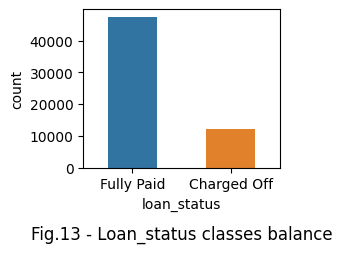

In [100]:
fig_id = 13

fig, ax = plt.subplots(figsize=(3, 3)) 
sns.countplot(data=data_copy, x='loan_status', width=0.5)
ax.set_title(f'Fig.{fig_id} - Loan_status classes balance', y=-0.5)
plt.tight_layout();

#plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

#print(targets['Sales_CLoans'].value_counts(True).round(2))

In [101]:
# encoding
y = y.apply(lambda x: 1 if x=='Fully Paid' else 0)

unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[0 1] [12034 47460]


In [102]:
X_copy, y_copy = X.copy(), y.copy()

### balancing classes

In [103]:
# Synthetic resampling of minority class
sm = SMOTE(random_state=random_seed)
X_copy, y_copy = sm.fit_resample(X_copy, y_copy)

unique, counts = np.unique(y_copy, return_counts=True)
print('After synthetic resampling : ',unique, counts)

After synthetic resampling :  [0 1] [47460 47460]


# 2. Modelling

In [104]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_copy, y_copy, test_size=0.2,  random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (75936, 42)
Test shape:  (9492, 42)
Valid shape: (9492, 42)


In [105]:
# def get_ROC_plot(model,  X_test, y_test, title:str, fig_id:int=None):
#     """
#     Create the roc curve plot
#     Args:
#         model (_type_): pre-trained model to get prediction
#         X_test (_type_): X matrice with 
#         y_test (_type_): y predicted values
#         title (_type_): _description_
#         figpath (_int_): figure path for saving
#     """
#     y_pred = model.predict_proba(X_test)[:,1]
#     metric = roc_auc_score(y_test, y_pred).round(3)
#     print('roc_auc: ', metric)

#     false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, y_pred)


#     # Plot
#     fig, ax = plt.subplots(figsize=(5, 5))

#     # ROC curve
#     ax.plot(false_positive_rates, true_positive_rates, 
#             label='Smoothed values ROC-AUC')

#     # Random model
#     ax.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
#             label='Model predicting random')

#     ax.set_title(f'Fig.{fig_id} - ROC curve for {title}', y=-0.2)
#     ax.set_xlabel('False Positive Rate')
#     ax.set_ylabel('True Positive Rate')

#     ax.fill_between(false_positive_rates, 
#                     true_positive_rates, 
#                     step="pre", 
#                     alpha=0.4, label='Area under curve (ROC-AUC)')
    
#     # Annotate figure with ROC curve
#     plt.annotate(f'ROC: {metric}', 
#         xy=(0.45,0.6), textcoords='data', 
#         bbox={'facecolor': 'w', 'alpha': 0.95, 'pad': 10} 
#     );
    
#     ax.legend()
#     plt.tight_layout();
    
#     if fig_id:
#         plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))
        

In [106]:
models_dict = dict()

### Random forest

              precision    recall  f1-score   support

           0       0.68      0.71      0.69      4728
           1       0.69      0.67      0.68      4764

    accuracy                           0.69      9492
   macro avg       0.69      0.69      0.69      9492
weighted avg       0.69      0.69      0.69      9492

roc_auc:  0.756


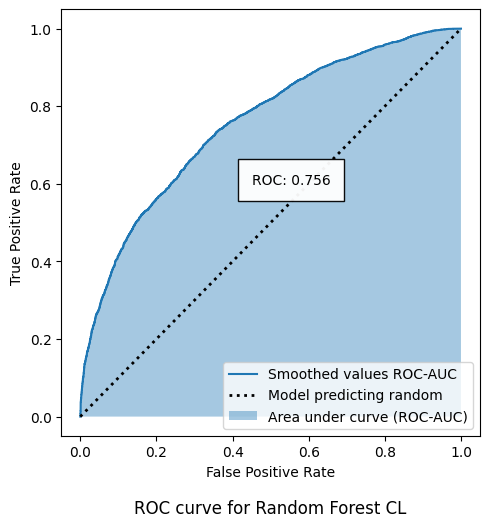

In [107]:
rf = RandomForestClassifier(
    n_estimators=110, 
    min_samples_leaf=5,
    max_depth=7,
    #verbose=1, 
    n_jobs=-1, 
    random_state=random_seed)

#Train model
rf.fit(X_train, y_train)

# Prediction
y_pred = rf.predict(X_test)

# Save results
models_dict.update({'random_forest':rf})

print(classification_report(y_test, y_pred))

get_ROC_plot(rf, X_test, y_test, 'Random Forest CL')

### Gradient boosting

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      4728
           1       0.68      0.61      0.65      4764

    accuracy                           0.66      9492
   macro avg       0.67      0.66      0.66      9492
weighted avg       0.67      0.66      0.66      9492

roc_auc:  0.728


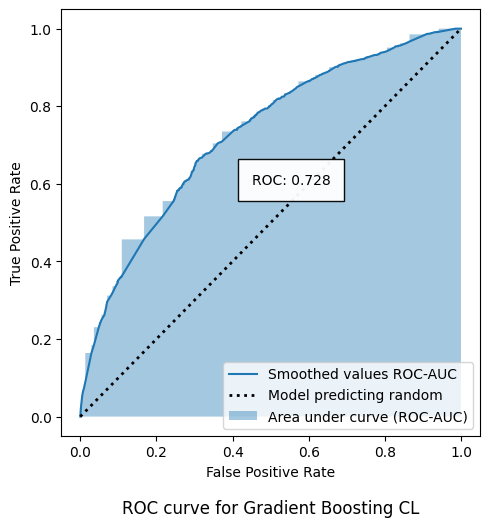

In [108]:
gb = GradientBoostingClassifier(
    learning_rate=0.01,
    n_estimators=95,
    min_samples_leaf=3,
    max_depth=3,
    random_state=random_seed
)

# train model
gb.fit(X_train, y_train)
 
# Predict target values
y_pred = gb.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred))

# Save results
models_dict.update({'gradient_boosting':gb})

get_ROC_plot(gb, X_test, y_test, 'Gradient Boosting CL')

In [109]:
from sklearn.metrics import confusion_matrix 
print(confusion_matrix(y_test, y_pred))

[[3388 1340]
 [1853 2911]]


## Models Comparison

In [110]:
# # Save model to the given path in the pkl format
# model_name = 'gbr_cl'
# full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
# #models_dict.update({'Revenue_CLoans':model_name})

# with open(full_path, 'wb') as f:
#     pickle.dump(gbr_cl, f)

## Other

### Gradient boosting + Optuna

In [112]:
def optuna_gb(trial):
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 300, 350, 1)
    max_depth = trial.suggest_int('max_depth', 5, 10, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    
    # model creation 
    model = GradientBoostingClassifier(
      n_estimators=n_estimators,
      learning_rate=learning_rate,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      random_state=random_seed)
    
    # training
    model.fit(X_train, y_train)
    y_pred = np.round(model.predict_proba(X_test)[:,1])
    F1_score = f1_score(y_test, y_pred)
    roc_score = roc_auc_score(y_test, y_pred)
    
    return F1_score, roc_score

#%%time
sampler = TPESampler(seed=random_seed) # fix random seed

# create study set
study = optuna.create_study(study_name="GBClassifier", directions=["maximize", "maximize"], sampler=sampler)
# try multiple times
study.optimize(optuna_gb, n_trials=5)
clear_output(wait=False)

optuna.visualization.plot_pareto_front(study, target_names=["F1_score", "roc_score"])

In [113]:
print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

best_hyperparameters = max(study.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
#print(f"\tnumber: {best_hyperparameters.number}")
print(f"\tparams: {best_hyperparameters.params}")
#print(f"\tvalues: {best_hyperparameters.values}")

Number of trials on the Pareto front: 1
Trial with highest accuracy: 
	params: {'n_estimators': 319, 'max_depth': 10, 'min_samples_leaf': 4, 'learning_rate': 0.0638792635777333}


              precision    recall  f1-score   support

           0       0.91      0.79      0.85      4728
           1       0.82      0.92      0.86      4764

    accuracy                           0.86      9492
   macro avg       0.86      0.86      0.86      9492
weighted avg       0.86      0.86      0.86      9492

roc_auc:  0.918


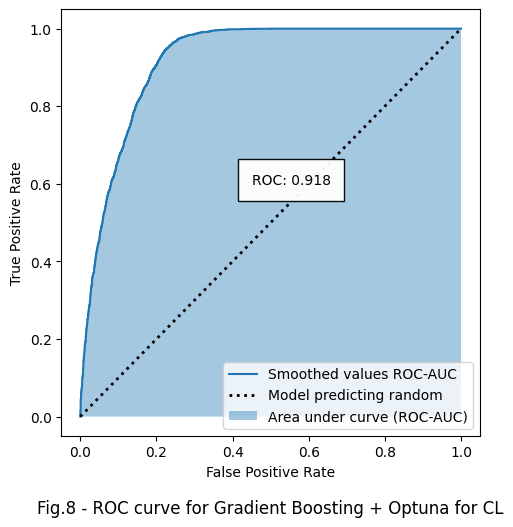

In [114]:
# Apply best parameters
gb_opt_cl = GradientBoostingClassifier(**best_hyperparameters.params, random_state=random_seed) #study.best_params
gb_opt_cl.fit(X_train, y_train)

# Predict target values
y_pred_gb_optu = gb_opt_cl.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred_gb_optu))

# Save results
models_dict.update({'g_boosting_opt':gb_opt_cl})

get_ROC_plot(gb_opt_cl, X_test, y_test, 'Gradient Boosting + Optuna for CL', plot_counter=8) #fig_id=3

roc_auc:  0.918


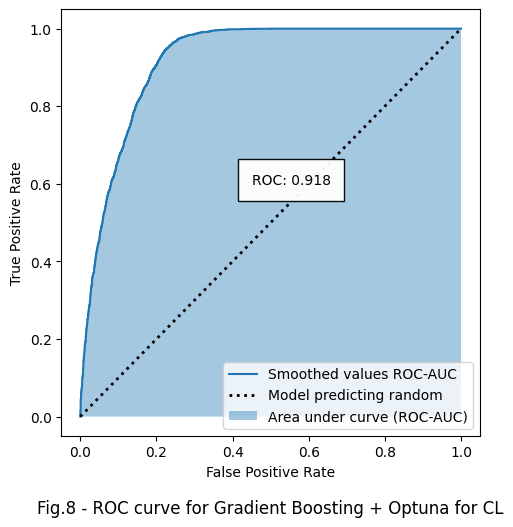

In [117]:
def get_ROC_plot1(model,  X_test, y_test, title:str,  plot_counter:int=None):
    """
    Create the roc curve plot
    Args:
        model (_type_): pre-trained model to get prediction
        X_test (_type_): X matrice with 
        y_test (_type_): y predicted values
        title (_type_): _description_
        figpath (_int_): figure path for saving
    """
    y_pred = model.predict_proba(X_test)[:,1]
    metric = roc_auc_score(y_test, y_pred).round(3)
    print('roc_auc: ', metric)

    false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, y_pred)


    # Plot
    fig, ax = plt.subplots(figsize=(5, 5))

    # ROC curve
    ax.plot(false_positive_rates, true_positive_rates, 
            label='Smoothed values ROC-AUC')

    # Random model
    ax.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
            label='Model predicting random')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    ax.fill_between(false_positive_rates, 
                    true_positive_rates, 
                    step="pre", 
                    alpha=0.4, label='Area under curve (ROC-AUC)')
    
    # Annotate figure with ROC curve
    plt.annotate(f'ROC: {metric}', 
        xy=(0.45,0.6), textcoords='data', 
        bbox={'facecolor': 'w', 'alpha': 0.95, 'pad': 10} 
    );
    
    ax.legend()
    plt.tight_layout();
    
    if plot_counter is not None:
        ax.set_title(f'Fig.{plot_counter} - ROC curve for {title}', y=-0.2)
        plt.savefig(path_figures + f'fig_{plot_counter}.png')
        
    else:
        #plot_counter=1
        ax.set_title(f'ROC curve for {title}', y=-0.2)
        
get_ROC_plot1(gb_opt_cl, X_test, y_test, 'Gradient Boosting + Optuna for CL', plot_counter=8)

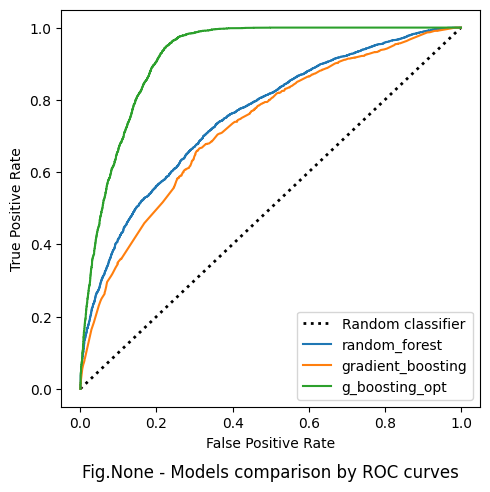

In [114]:
get_comparison(models_dict, X_test, y_test)

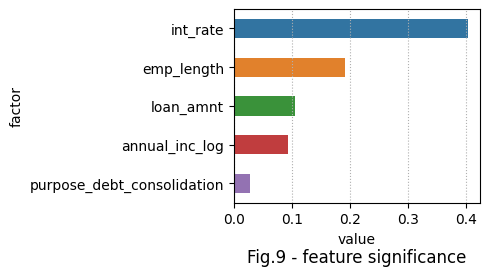

In [115]:
# arrays names and values
f_keys, f_values = np.array(X_train.columns), gb_opt_cl.feature_importances_
# sort and reverse arrays
idx   = np.argsort(f_values)[::-1]

f_keys, f_values = np.array(f_keys)[idx], np.array(f_values)[idx]

# Table
f_keys, f_values = np.array(f_keys)[idx], np.array(f_values)[idx]

factors = pd.DataFrame({'factor':f_keys,
              'value':f_values
}).sort_values(by='value', ascending=False).head(5)

plot_counter=9

# display a bar chart
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(factors, x='value', y='factor', width=0.5)
#ax.grid()
ax.set_title(f'Fig.{plot_counter} - feature significance', y=-0.35); 
plt.tight_layout()
#major_ticks = np.linspace(0.00, 0.4, 5)
#ax.set_xticks(major_ticks)
#ax.set_xlim(0,0.2)
ax.xaxis.grid(linestyle=':');

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

# Нужно проверить

In [ ]:
# temp1 = data[(data['loan_status']=='Fully Paid') | (data['loan_status']=='Charged Off')]
# #x = temp1[(temp1['loan_status']=='Charged Off') & (temp1['total_pymnt']>0)][['loan_status','loan_amnt',   'total_pymnt']].round() #'grade'
# #x.loc['Total'] = x.sum()
# mask = temp1['loan_status']=='Charged Off'
# temp1[mask][['loan_status','loan_amnt', 'total_rec_int', 'total_rec_prncp',  'total_pymnt']].round()
# temp1['total_earned'] = temp1['total_rec_int'] + temp1['total_rec_prncp']
# temp1['total_loss'] = temp1['loan_amnt'] - temp1['total_earned']
# x = temp1[mask][['loan_amnt','total_earned','total_loss']].round()
# x

,loan_amnt,total_earned,total_loss
18,12000.0,4448.0,7552.0
23,12375.0,6833.0,5542.0
32,18000.0,15071.0,2929.0
44,20000.0,10059.0,9941.0
...,...,...,...
99963,8000.0,2684.0,5316.0
99970,28000.0,10484.0,17516.0
99982,20000.0,3707.0,16293.0
99986,5000.0,4671.0,329.0


# 3. Interest rate modelling

### Check for multicollinearity

In [ ]:
X, y = data.drop(['int_rate','loan_status', 'grade', 'sub_grade'], axis=1), np.log(data['int_rate'])

num_features = [s for s in X.columns if X[s].dtypes != 'object']
сat_features = [s for s in X.columns if X[s].dtypes == 'object' or X[s].dtypes == 'category']

In [ ]:
transformer = make_column_transformer(
    (StandardScaler(), num_features),
    (OneHotEncoder(sparse=False,drop='if_binary'), сat_features), remainder = 'passthrough') 

transformer = transformer.fit(X)
results = transformer.transform(X)

results = pd.DataFrame(results, columns=transformer.transformers_[0][1].get_feature_names_out().tolist() + transformer.transformers_[1][1].get_feature_names_out().tolist())

In [ ]:
# check for missing values
imputer =  KNNImputer(n_neighbors=5, weights="uniform", metric='nan_euclidean')
X = pd.DataFrame(imputer.fit_transform(results), columns=results.columns)

# check if nan are present in the dataset
for i in X.columns:
    assert X[i].isna().sum()== 0

### Check for multicollinearity

In [ ]:
# select features with correlation coefficient > 0.7
pivot = X.corr()

for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.7 or x == 1) else x)
    
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

high_correlation_features = list(pivot.columns) # список признаков c высокой корреляцией
pivot 

print('Features with high correlation coef:')
for count, value in enumerate(high_correlation_features, start=1): # list features from 1
    print(count, value)

Features with high correlation coef:
1 home_ownership_MORTGAGE
2 home_ownership_RENT


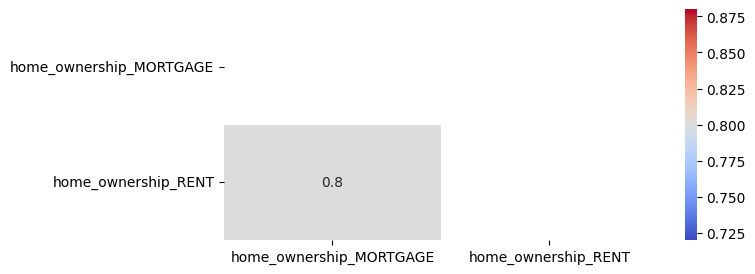

In [ ]:
# heatmap
fig = plt.figure(figsize=(7, 3))
matrix = np.triu(pivot)
sns.heatmap(round(abs(pivot), 2), annot=True, cmap= 'coolwarm', mask=matrix);

In [ ]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,  random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (48520, 33)
Test shape:  (6065, 33)
Valid shape: (6065, 33)


In [ ]:
X.head(2)

,loan_amnt,emp_length,annual_inc_log,term_60_m,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,-0.554286,-0.907889,-1.874422,0.0,...,0.0,0.0,0.0,0.0
1,-1.193007,-0.528985,0.427559,0.0,...,0.0,0.0,0.0,0.0


## Linear model

In [ ]:
# Creation an instance
lin_cl = LinearRegression()

# Train the Model
lin_cl.fit(X_train, y_train)

# Predict target values
y_pred_lin = lin_cl.predict(X_test)

print(f'MSE: {round(mean_squared_error(y_test, y_pred_lin),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_lin)*100,2)} %')

MSE: 0.0
MAPE: 2.08 %


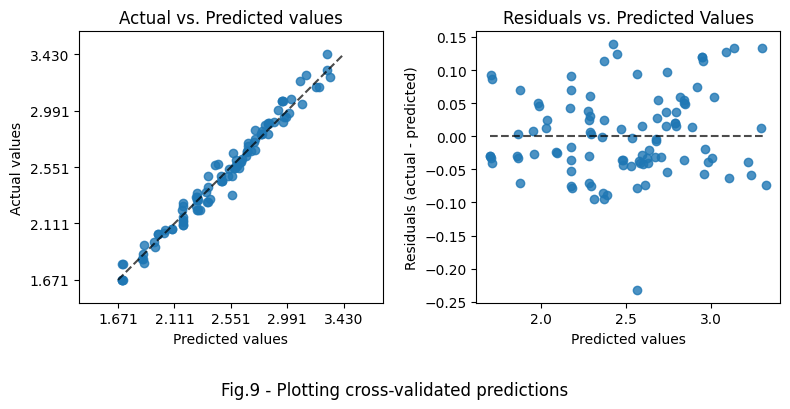

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_lin,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_lin,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');

## Gradient boosting

In [ ]:
gbr_cl = GradientBoostingRegressor(
    max_depth=5,
    n_estimators=300,
    random_state=random_seed 
)
# Model training
gbr_cl.fit(X_train, y_train)

# Predict target values
y_pred_gbr = gbr_cl.predict(X_test)

print(f'MSE: {round(mean_squared_error(y_test, y_pred_gbr),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_gbr)*100,2)} %')

MSE: 0.09
MAPE: 10.15 %


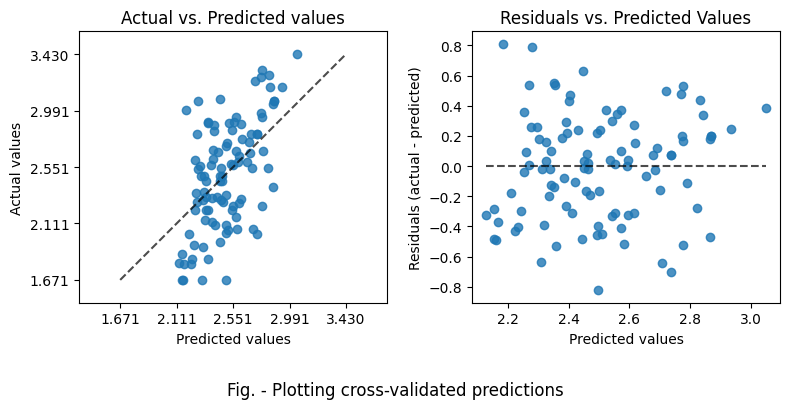

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_gbr,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_gbr,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');

## Model comparison

In [ ]:
# Save model to the given path in the pkl format
model_name = 'gbr_cl'
full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
#models_dict.update({'Revenue_CLoans':model_name})

with open(full_path, 'wb') as f:
    pickle.dump(gbr_cl, f)

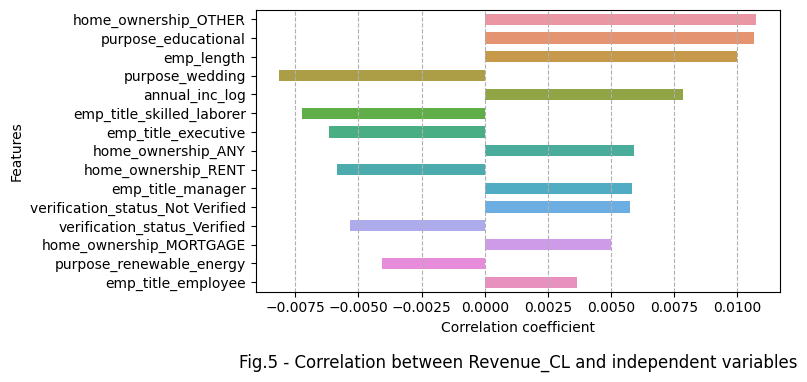

In [ ]:
# correlation scores with the dependent variable
corr_df = X.corrwith(data['int_rate'], method='pearson')
corr_df = pd.DataFrame({'corr_value':corr_df})

corr_df.sort_values(by='corr_value', key=abs, ascending=False, inplace=True)#.round(2).to_dict()

fig_id=5
fig, ax = plt.subplots(figsize=(8, 4))
hist = sns.barplot(corr_df[:15], x='corr_value' , y=corr_df.index[:15], width=0.6);

hist.set(xlabel='Correlation coefficient', ylabel='Features')
ax.set_title(f'Fig.{fig_id} - Correlation between int_rate and independent variables', y=-0.3);
#major_ticks = np.linspace(-0.1, 0.1, 3)
#ax.set_xticks(major_ticks)
ax.xaxis.grid(linestyle='--')
plt.tight_layout()

plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

In [ ]:
corr_df.sort_values(by='corr_value', key=abs, ascending=False).index

# Revenue calculation

In [ ]:
data.head()

,loan_amnt,term,int_rate,grade,...,annual_inc_log,verification_status,pymnt_plan,purpose
1,9600.0,36_m,12.99,C,...,9.994242,Verified,n,debt_consolidation
2,4000.0,36_m,6.68,A,...,11.326596,Not Verified,n,major_purchase
3,6025.0,36_m,10.91,B,...,10.858999,Not Verified,n,debt_consolidation
5,20000.0,36_m,9.49,B,...,11.512925,Not Verified,n,debt_consolidation
6,1000.0,36_m,8.18,B,...,10.043249,Verified,n,debt_consolidation


# Other features

### settlement_percentage

In [ ]:
get_descr('hardship_length')

The number of months the borrower will make smaller payments than normally obligated due to a hardship plan


In [ ]:
#data['hardship_length'].value_counts()

3.0    299
Name: hardship_length, dtype: int64

### Member_id

We will not use this feature for prediction.

In [ ]:
#data.drop(['member_id'], axis=1, inplace=True)

### hardship_length

In [ ]:
get_descr(feature='hardship_length')

The number of months the borrower will make smaller payments than normally obligated due to a hardship plan


In [ ]:
#data['hardship_length'].value_counts()

3.0    299
Name: hardship_length, dtype: int64

In [ ]:
# Encoding data 
data['hardship_length'] = data['hardship_length'].apply(lambda x: 1 if x==3.0 else 0) 

### settlement_percentage

In [ ]:
get_descr('settlement_percentage')

The settlement amount as a percentage of the payoff balance amount on the loan


In [ ]:
data['settlement_percentage'].unique()

array([  nan, 59.98, 50.  , 60.01, 60.  , 55.  , 50.03, 45.  , 49.99,
       44.99, 50.01, 45.01, 65.  , 55.01, 44.97])

In [ ]:
data['settlement_percentage'].fillna(-1, inplace=True)

In [ ]:
data['settlement_percentage_group'] = pd.cut(data['settlement_percentage'], [-2,1,45,50,55,60,100], labels = ['unknown','<45','45-50','50-55','55-60','60+'])
data['settlement_percentage_group'].value_counts()

unknown    87461
<45           14
45-50         13
50-55          7
55-60          4
60+            4
Name: settlement_percentage_group, dtype: int64

In [ ]:
data.drop(['settlement_percentage'],axis=1, inplace=True)

### total_bal_il

In [ ]:
get_descr('total_bal_il')

Total current balance of all installment accounts


<AxesSubplot: xlabel='total_bal_il'>

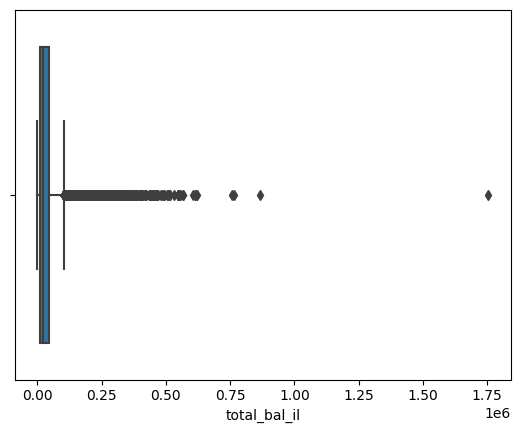

In [ ]:
sns.boxplot(data=data, x='total_bal_il')

<AxesSubplot: ylabel='total_bal_il'>

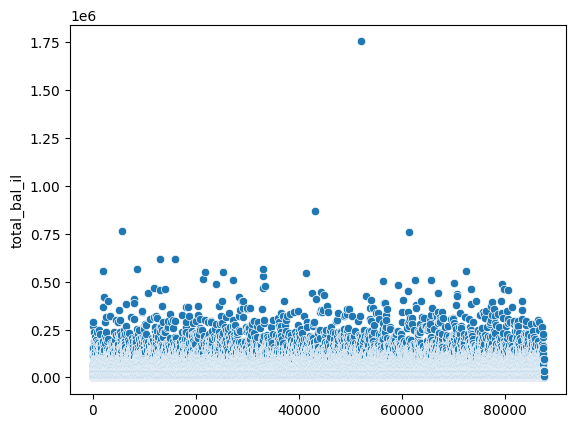

In [ ]:
sns.scatterplot(data['total_bal_il'])

In [ ]:
data['total_bal_il'].isna().value_counts()

False    76590
True     10913
Name: total_bal_il, dtype: int64

### emp_title

In [ ]:
data['emp_title']

0                            Public Service
1                                       NaN
2                            System Analyst
3                           Admin assistant
                        ...                
99996                                   CEO
99997    Austin Independent School District
99998                               Manager
99999                   Locomotive Engineer
Name: emp_title, Length: 87503, dtype: object

In [ ]:
data['emp_title'].fillna('Unknown', inplace=True)

### total_bal_il

In [ ]:
get_descr('total_bal_il')

Total current balance of all installment accounts


In [ ]:
data['total_bal_il'].

In [ ]:
cols_null_percent = data.isna().mean()*100
cols_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_null)

total_bal_il            36.092477
emp_length               6.263785
mort_acc                 1.942791
title                    0.866256
dti                      0.085711
revol_util               0.063998
pub_rec_bankruptcies     0.033142
dtype: float64

In [ ]:
data['debt_settlement_flag_date'] = pd.to_datetime(data['debt_settlement_flag_date'], dayfirst=False).dt.date
data['debt_settlement_flag_date'].value_counts()

In [ ]:
data['debt_settlement_flag_date'].isna().count()

87503

## Next section

Let us encode the feature manually: 

<AxesSubplot: >

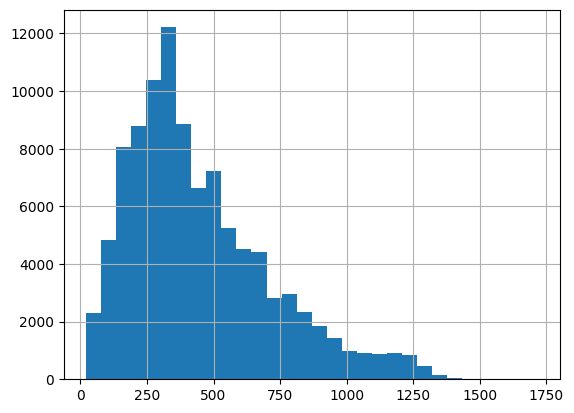

In [ ]:
data['installment'].hist(bins=30)

In [ ]:
data['term'].value_counts(True)

 36 months    0.710658
 60 months    0.289342
Name: term, dtype: float64

In [ ]:
data.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,...,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,99996.00000,99996.000000,99996.000000,...,490.000000,1585.000000,1585.000000,1585.000000
mean,NaN,15081.25750,15076.493310,15060.101482,...,196.677469,5036.891691,47.700315,13.021451
std,NaN,9214.65121,9213.200242,9216.652945,...,195.609417,3690.770500,6.785504,8.124088
min,NaN,1000.00000,1000.000000,0.000000,...,0.020000,203.000000,15.000000,0.000000
25%,NaN,8000.00000,8000.000000,8000.000000,...,50.220000,2206.000000,45.000000,6.000000
50%,NaN,13000.00000,13000.000000,12900.000000,...,135.330000,4106.000000,45.000000,13.000000
75%,NaN,20000.00000,20000.000000,20000.000000,...,287.055000,6911.000000,50.000000,18.000000
max,NaN,40000.00000,40000.000000,40000.000000,...,1187.560000,23766.000000,90.000000,36.000000


In [ ]:
data.columns.to_list()

['member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joi

In [ ]:
sns.histplot(data, y='loan_status')

<AxesSubplot: xlabel='loan_amnt'>

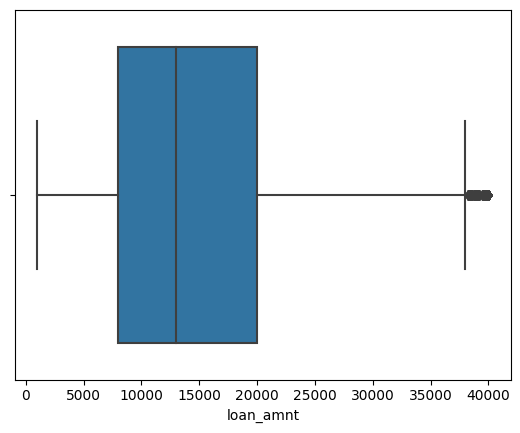

In [ ]:
sns.boxplot(df, x='loan_amnt')

In [ ]:
columns_list = df.columns.to_list()
columns_list

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

## Transformer

In [ ]:
transformer = make_column_transformer(
    (StandardScaler(), num_features),
    (OneHotEncoder(sparse=False), сat_features), remainder = 'passthrough') #OneHotEncoder(sparse=False)
#transformer

pipeline = Pipeline([
    ('ct', transformer), 
    ('imputer', KNNImputer(n_neighbors=5, weights="uniform", metric='nan_euclidean')),
    # ('log_reg', LogisticRegression(
    #     multi_class='multinomial',  
    #     max_iter=5000,  
    #     random_state=random_seed))
    ('gb', GradientBoostingClassifier(
        learning_rate=0.01,
        n_estimators=95,
        min_samples_leaf=3,
        max_depth=3,
        random_state=random_seed))
])

In [ ]:
pipeline['ct'].transformers_[1][1].get_feature_names_out().tolist()

['term_ 36 months',
 'term_ 60 months',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'emp_title_employee',
 'emp_title_executive',
 'emp_title_manager',
 'emp_title_other',
 'emp_title_skilled_laborer']

In [ ]:
transformer = transformer.fit(X)
results = transformer.transform(X)